In [214]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage.metrics import structural_similarity as compare_ssim

filenames = os.listdir('data1/00_43_47/original')
filenames.sort()

def add(img1, img2):
    return cv2.addWeighted(img1, 1, img2, 1, 0)
def sub(img1, img2):
    return cv2.addWeighted(img1, 1, img2, -1, 0)

def process(img, buffer):
    scores = calc_rail_prob(cv2.inRange(img, (110, 110, 100), (150, 140,140)))
    rail_r = max([i for i,v in enumerate(scores) if v > 0.9])
    rail_l = min([i for i,v in enumerate(scores) if v > 0.9])
#     gray = cv2.inRange(img, (110, 110, 100), (150, 140,140))
#     gray = cv2.convertScaleAbs(gray, alpha=1, beta=100)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
#     blur_gray = cv2.dilate(blur_gray, np.ones((5, 5), 'uint8'), iterations=1)
#     blur_gray = cv2.GaussianBlur(blur_gray,(kernel_size, kernel_size),0)
    low_threshold = 200
    high_threshold = 300
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 15  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 30  # minimum number of pixels making up a line
    max_line_gap = 20  # maximum gap in pixels between connectable line segments
    line_image = np.copy(img) * 0  # creating a blank to draw lines on
    lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)
    for line in lines:
        for x1,y1,x2,y2 in line:
            if abs(x1 - x2) < 20:
                continue
            if x2 > rail_r:
                continue
            if x1 > rail_r:
                continue
            if x2 < rail_l:
                continue
            if x1 < rail_l:
                continue
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)
    
    buffer.append(line_image)
    
    if len(buffer) >= 1:
        line_image = add(line_image, buffer[-1])
    if len(buffer) >= 2:
        line_image = add(line_image, buffer[-2])
    if len(buffer) >= 3:
        line_image = add(line_image, buffer[-3])
    if len(buffer) >= 4:
        line_image = add(line_image, buffer[-4])
    
    for i in range(1, 30):
        shape = scores.shape[0]
        line_image[-i] = np.array([scores * 255,np.zeros(shape),np.zeros(shape)]).reshape(shape,3)
    
    if len(buffer) >= 5:
        buffer.pop(0)
    return line_image

def calc_rail_prob(img):
    scores = np.sum(np.subtract(img, np.roll(img, 1, 0)), axis=0)
    ms = max(scores)
    scores = scores / ms
    return scores

buffer = []
for filename in tqdm(filenames):
    image = cv2.imread('data1/00_43_47/original/'+filename)
    line_image = process(image, buffer)
    cv2.imwrite('data1/00_43_47/lines/'+filename, line_image)
#     plt.figure(figsize=(20,20))
#     plt.imshow(line_image)
#     break

100%|████████████████████████████████████████████████████████████████| 419/419 [00:25<00:00, 16.57it/s]


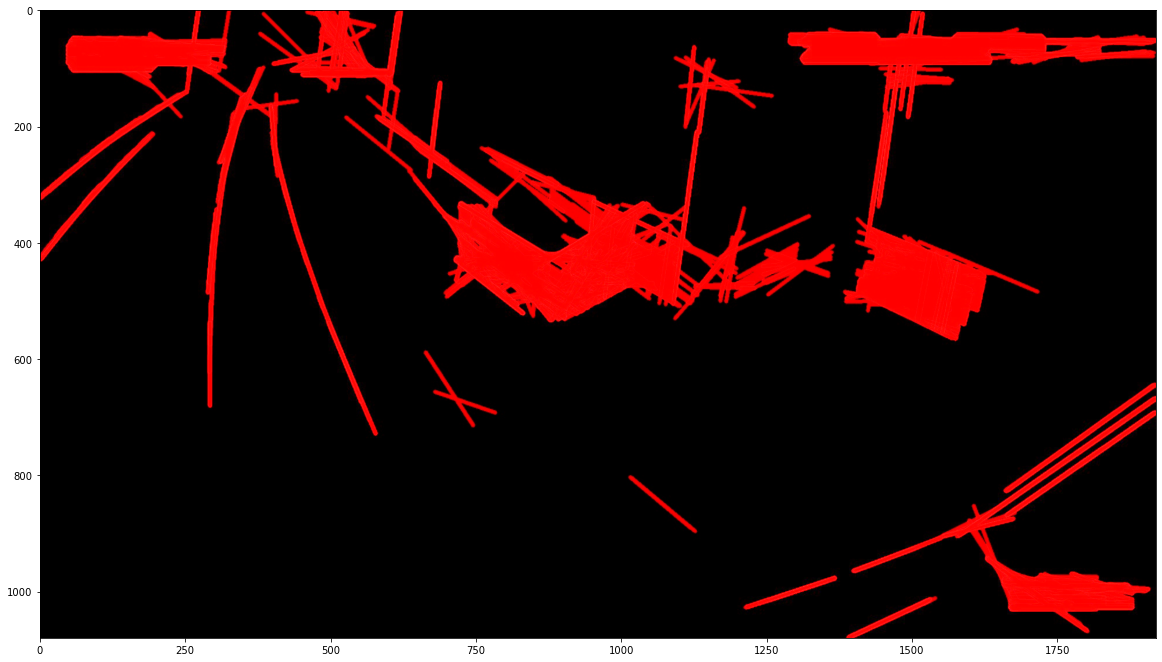

In [94]:
def add(img1, img2):
    return cv2.addWeighted(img1, 1, img2, 1, 0)

def process():
    img1 = cv2.imread('data1/00_43_47/lines/001.jpg')
    img2 = cv2.imread('data1/00_43_47/lines/002.jpg')
    img3 = cv2.imread('data1/00_43_47/lines/003.jpg')
    img4 = cv2.imread('data1/00_43_47/lines/004.jpg')
    img5 = cv2.imread('data1/00_43_47/lines/005.jpg')
    img = add(img1, img2)
    img = add(img, img3)
    img = add(img, img4)
    img = add(img, img5)
    plt.figure(figsize=(20,20))
    plt.imshow(img)
process()